In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sci
from PyDSTool import *
import scipy.optimize as sco
from scipy import optimize
from scipy.interpolate import interp1d
import mpld3
from tabulate import tabulate

## Parameters and Initial Conditions

In [103]:
# parameter definitions, not sure which to optimize yet
V_max_AADC = 400
k_m_AADC = 160
V_max_SERT = 8000
k_m_SERT = 0.17 # literature values 0.05-1
K_bh2_DRR = 100 # literature values 4-754
K_NADPH_DRR = 75 # literature values 29-770
V_max_f_DRR = 5000
V_max_b_DRR = 3
K_bh4_DRR = 10 # literature values 1.1-17
K_NADP_DRR = 75 # literature values 29-770
K_m_MAT = 0.198 # literature values 0.123-0.253
V_max_MAT = 3500
k_out_MAT = 40
V_max_TPH = 400
K_bh4_TPH = 20 # literature value 20
K_trp_TPH = 40 # literature value 40
K_i_TPH = 1000 # literature value 970
K_m_trpin = 64 # literature value 64
V_max_trpin = 400
k_f_trppool = 6
k_b_trppool = 0.6
k_catab_trp = 0.2
V_max_catab_c5ht = 1000
K_m_catab_c5ht = 95 # literature values 94-95
V_max_catab_e5ht = 1000
K_m_catab_e5ht = 95 # literature values 94-95
k_hiaa_catab = 1 # literature value 0.82
k_trppool_catab = 0.2
k_rem = 400
NADP = 26
NADPH = 330
#btrp = 96 # varied in Results A with meals
btrp = 0.59*97

params = [V_max_AADC, k_m_AADC, V_max_SERT, k_m_SERT, K_bh2_DRR, K_NADPH_DRR, V_max_f_DRR, V_max_b_DRR, K_bh4_DRR, K_NADP_DRR, K_m_MAT, V_max_MAT, k_out_MAT, V_max_TPH, K_bh4_TPH, K_trp_TPH, K_i_TPH, K_m_trpin, V_max_trpin, k_f_trppool, k_b_trppool, k_catab_trp, V_max_catab_c5ht, K_m_catab_c5ht, V_max_catab_e5ht, K_m_catab_e5ht, k_hiaa_catab, k_trppool_catab, k_rem, NADP, NADPH]


In [251]:
# initial conditions
y0 = [0.14,0.86,20.6,2.26,0.5,21.45,0.000768,5.26,144.9] # steady state values reported in paper, but not what I'm getting
#y0 = [0.0995, 0.9005, 20.1651, 1.611, 0.0376, 67.4267, 0.0601, 1.5846, 113.4289] # values taken from 2020 paper

# bounds for optimization
bounds = [(360,440), (144,176), (7200,8800), (0.05,1), (4,754), (29,770), (4500,5500), (2.7,3.3), (1.1,17), (29,770), (0.123,0.253), (3150,3850), (36,44), (360,440), (18,22), (36,44), (900,1100), (57.6,70.4), (360,440), (5.4,6.6), (0.54,0.66), (0.18,0.22), (900,1100), (85.5, 104.5), (900,1100), (85.5,104.5), (0.64,1.18), (0.18,0.22), (360,440)]

In [259]:
# length of time over which we wish to integrate
timeLength = (0,10.01)

# time interval and step definition, based on XPP model from authors
t_start = 0
t_end = 10.01
t_step = 0.01

In [260]:
# change this variable to change the time scale from hours (sc = 1) to minutes (sc = 1/60) or seconds (sc = 1/3600)
sc = 1/3600

## Put Raw Data Into Arrays

In [7]:
# no raw data yet

## Model Function -- Includes ODE Solver

In [269]:
btrp_data = []

def model(params, ics, t):
    def ode_system(t, y):
        dy = np.zeros(9)
        
        # unpack the current parameter set from the optimization
        [V_max_AADC, k_m_AADC, V_max_SERT, k_m_SERT, K_bh2_DRR, K_NADPH_DRR, V_max_f_DRR, V_max_b_DRR, K_bh4_DRR, K_NADP_DRR, K_m_MAT, V_max_MAT, k_out_MAT, V_max_TPH, K_bh4_TPH, K_trp_TPH, K_i_TPH, K_m_trpin, V_max_trpin, k_f_trppool, k_b_trppool, k_catab_trp, V_max_catab_c5ht, K_m_catab_c5ht, V_max_catab_e5ht, K_m_catab_e5ht, k_hiaa_catab, k_trppool_catab, k_rem, NADP, NADPH] = params
        
        # set the serum tryptamine value to 59% of normal during off meal hours and 200% of normal from 7-9AM, 12-2PM
        # and 6-8PM
        btrp = meal(t)
        btrp_data.append([t,meal(t)])

        # define the system
        dy[0] = V_TPH(V_max_TPH, K_bh4_TPH, K_trp_TPH, K_i_TPH, y[2], y[1], y[6], sc) - V_DRR(K_bh2_DRR, K_NADPH_DRR, V_max_f_DRR, V_max_b_DRR, K_bh4_DRR, K_NADP_DRR, y[0], NADPH, y[1], NADP, sc)
        dy[1] = V_DRR(K_bh2_DRR, K_NADPH_DRR, V_max_f_DRR, V_max_b_DRR, K_bh4_DRR, K_NADP_DRR, y[0], NADPH, y[1], NADP, sc) - V_TPH(V_max_TPH, K_bh4_TPH, K_trp_TPH, K_i_TPH, y[2], y[1], y[6], sc)
        dy[2] = V_trpin(K_m_trpin, V_max_trpin, btrp, sc) - V_TPH(V_max_TPH, K_bh4_TPH, K_trp_TPH, K_i_TPH, y[2], y[1], y[6], sc) - V_trppool(k_f_trppool, k_b_trppool, y[2], y[7], sc) - k_catab_trp*y[2]*sc #+ meal(t)*y[2]
        dy[3] = V_TPH(V_max_TPH, K_bh4_TPH, K_trp_TPH, K_i_TPH, y[2], y[1], y[6], sc) - V_AADC(V_max_AADC, k_m_AADC, y[3], sc)
        dy[4] = V_AADC(V_max_AADC, k_m_AADC, y[3], sc) - V_MAT(V_max_MAT, K_m_MAT, k_out_MAT, y[4], y[5], sc) + fluox(t)*V_SERT(V_max_SERT, k_m_SERT, y[6], sc) - V_c5ht_catab(V_max_catab_c5ht, K_m_catab_c5ht, y[4], sc)
        dy[5] = V_MAT(V_max_MAT, K_m_MAT, k_out_MAT, y[4], y[5], sc) - release(y[6])*fire(t)*y[5]*sc
        dy[6] = release(y[6])*fire(t)*y[5]*sc - fluox(t)*V_SERT(V_max_SERT, k_m_SERT, y[6], sc) - V_e5ht_catab(V_max_catab_e5ht, K_m_catab_e5ht, y[6], sc) - k_rem*y[6]*sc
        dy[7] = V_c5ht_catab(V_max_catab_c5ht, K_m_catab_c5ht, y[4], sc) + V_e5ht_catab(V_max_catab_e5ht, K_m_catab_e5ht, y[6], sc) - k_hiaa_catab*y[7]*sc
        dy[8] = V_trppool(k_f_trppool, k_b_trppool, y[2], y[7], sc) - k_trppool_catab*y[8]*sc
        
        return dy
    
    # I'm making the various velocity functions into actual functions to help with readability 
    #     and ease of editing of the ODEs
    def V_TPH(V_max, K_bh4, K_trp, K_i, trp, bh4, e5ht, scale):
        return ((V_max*trp*bh4)/((K_trp+trp+(trp**2)/K_i)*(K_bh4+bh4))*(1.5-((e5ht**2)/(.000768**2+e5ht**2))))*scale
    
    def V_DRR(K_bh2, K_NADPH, V_max_f, V_max_b, K_bh4, K_NADP, bh2, NADPH, bh4, NADP, scale):
        return ((V_max_f*NADPH*bh2)/((K_NADPH+NADPH)*(K_bh2+bh2))-(V_max_b*NADP*bh4)/((K_NADP+NADP)*(K_bh4+bh4)))*scale
    
    def V_trpin(K_m, V_max, _btrp, scale):
        return ((V_max*_btrp)/(K_m+_btrp))*scale
    
    def V_trppool(k_f, k_b, trp, trppool, scale):
        return (k_f*trp - k_b*trppool)*scale
    
    def V_AADC(V_max, K_m, htp, scale):
        return ((V_max*htp)/(K_m+htp))*scale
    
    def V_MAT(V_max, K_m, k_out, c5ht, v5ht, scale):
        return ((V_max*c5ht)/(K_m+c5ht)-(k_out*v5ht))*scale
    
    # Returns 1 unless we want the model to simulate using SSRIs
    # by turning off SERTs to a degree
    def fluox(t):
        # baseline case, return 1:
        return 1
        
        # results B case:
        #return 0.5
    
        # results E case:
        #if (t<=1):
        #    return 1
        #else:
        #    return (1 - ((0.95*(t-1)**2)/(0.04+(t-1)**2))*np.exp(-1*(t-1)/37))
    
    def V_SERT(V_max, K_m, e5ht, scale):
        return ((V_max*e5ht)/(K_m+e5ht))*scale
    
    def V_c5ht_catab(V_max, K_m, c5ht, scale):
        return ((V_max*c5ht)/(K_m+c5ht))*scale
    
    def V_e5ht_catab(V_max, K_m, e5ht, scale):
        return ((V_max*e5ht)/(K_m+e5ht))*scale
    
    def release(e5ht):
        if (e5ht <= .000768):
            return (-651.04167*e5ht + 1.5)
        elif (.000768 < e5ht <= .0023):
            return (-391.3*e5ht + 1.3)
        else:
            return 0.4
    
    # we use this modified form for Results B to change the firing rate of the neuron
    def fire(t):
        if (0 <= t <= 0.2):
            return 5000
        else:
            return 1
    
    # use this version of fire(t) for baseline simulations
    #def fire(t):
    #    return 1
    
    # use this version of meal(t) for baseline simulations
    def meal(t):
        return 96
    
    # the way btrp is set in the code Dr Best sent me
    #def meal(t):
    #    if (7 <= t <= 9):
    #        return (2*97)
    #    elif (12 <= t <= 14):
    #        return (2*97)
    #    elif (18 <= t <= 20):
    #        return (2*97)
    #    else:
    #        return (0.59*97)
    # piecewise meal function to try matching what their figure actually looks like
    #def meal(t):
    #    if (7 <= t <= 9):
    #        return 34.1925*(t%7)**2 + (0.59*97)
    #    elif (9 < t <= 10):
    #        return 60.5197*np.abs((t%9)-1)**(1/3) + (2*97 - 60.5197)
    #    elif (10 < t < 12):
    #        return -60.5197*((t%9) - 1)**(1/3) + (2*97 - 60.5197)
    #    elif (12 <= t <= 14):
    #        return 34.1925*(t%12)**2 + (0.59*97)
    #    elif (14 < t <= 15):
    #        return 60.5197*np.abs((t%14)-1)**(1/3) + (2*97 - 60.5197)
    #    elif (15 < t < 18):
    #        return -56.0017*((t%14) - 1)**(1/3) + (2*97 - 56.0017)
    #    elif (18 <= t <= 20):
    #        return 34.1925*(t%18)**2 + (0.59*97)
    #    elif (20 < t <= 21):
    #        return 60.5197*np.abs((t%20)-1)**(1/3) + (2*97 - 60.5197)
    #    elif (21 < t <= 24):
    #        return -56.0017*((t%20) - 1)**(1/3) + (2*97 - 56.0017)
    #    else:
    #        return (0.59*97)
    
    
    # solve the system with scipy.integrate.ode
    solver = sci.ode(ode_system)
    solver.set_integrator('vode', method='bdf', order = 5, nsteps = 1000000) # had been using options: atol=3e-16, rtol=1e-14
    solver.set_initial_value(ics, t_start)
    
    ts = []
    ys = []
    
    while solver.successful() and solver.t < t_end:
        solver.integrate(solver.t + t_step)
        ts.append(solver.t)
        ys.append(solver.y)

    # reshape the output frome ode to an array with the times on the first column
    ts = np.reshape(ts, (len(ts),1))
    ys = np.vstack(ys)
    timeSeries = np.hstack((ts, ys))
    return timeSeries
    

## Cost Function

In [26]:
def cost_fun(params):
    # call the solve function
    simData = model(params, y0, timeLength)
    
    # this is where Rick makes sure we only have unique values for t, so no time step is repeated
    # I'll include it commented out here, and see if it changes anything later
    #idx = np.unique(simData[:,0], return_index = True)
    #idx = idx[1]
    #simData = simData[idx,:]
    
    # perform a cubic interpolation between time steps of model data
    spline_SER = interp1d(simData[:,0], simData[:,3], kind = 'cubic')
    
    # compute the actual cost value for the current parameter set by finding SSE between raw data and splines
    # this is where we change the data set we are trying to match, so that it computes the cost based on whatever
    #     data set we put in as the x values into the spline and the y values to subtract
    cost = np.sum((spline_CORT(yehudaControlCortisol_smooth[:,0]) - yehudaControlCortisol_smooth[:,1])**2)
    
    # if i run it with other data, also, can make cost the average of SSEs for serotonin and whatever else the data
    # includes
    #cost = (acthSSE+cortSSE)/2
    # for now though, cost is just the SSE of serotonin data and simulation
    
    return cost

## Run the Optimization

In [ ]:
# number of times to run the optimization
n = 100

# define an array to hold the population of parameter vectors
opt_pars = np.zeros((n, len(bounds)+1))

# initialize arrays to save simulation data from each optimization
sims_bh2 = np.zeros((2401,n))
sims_bh4 = np.zeros((2401,n))
sims_trp = np.zeros((2401,n))
sims_htp = np.zeros((2401,n))
sims_c5ht = np.zeros((2401,n))
sims_v5ht = np.zeros((2401,n))
sims_e5ht = np.zeros((2401,n))
sims_hiaa = np.zeros((2401,n))
sims_trppool = np.zeros((2401,n))

In [ ]:
%%time

# loop n times, running the optimization each time
for i in range(0,n):
    
    print(f"Optimization Run #{i+1}")
    
    # call the differential evolution optimization function on the cost function
    res = sco.differential_evolution(cost_fun, bounds, maxiter = None, disp = True, popsize = 1)
    
    # alternatively, we can run the SHGO algorithm with the sampling_method = "sobol" flag to do global
    #     optimization with reporting all local minima, as well
    #res = sco.shgo(cost_fun, bounds, callback=callback_fun(*shgo_iter_steps), options = {"f_min": 0.1, "maxiter": None, "minimize_every_iter": True, "local_iter": False, "disp": True}, iters = 3)
    #res = sco.basinhopping(cost_fun, x0, niter = 1000)
    #res = sco.dual_annealing(cost_fun, bounds)
    
    # plug the optimized parameters into the solver
    optimizedSimData = model(res.x, y0, timeLength)
    
    # save CRH, cortisol and ACTH data into sims arrays
    sims_bh2[:,i] = optimizedSimData[:,1]
    sims_bh4[:,i] = optimizedSimData[:,2]
    sims_trp[:,i] = optimizedSimData[:,3]
    sims_htp[:,i] = optimizedSimData[:,4]
    sims_c5ht[:,i] = optimizedSimData[:,5]
    sims_v5ht[:,i] = optimizedSimData[:,6]
    sims_e5ht[:,i] = optimizedSimData[:,7]
    sims_hiaa[:,i] = optimizedSimData[:,8]
    sims_trppool[:,i] = optimizedSimData[:,9]
    
    # save the cost function values and optimized parameters for each iteration into the array opt_pars
    opt_pars[i,0] = res.fun
    opt_pars[i,1:] = res.x

## Reproduce Figures from Paper

In [252]:
%%time

data = model(params, y0, timeLength)

CPU times: user 13min 20s, sys: 3.37 s, total: 13min 23s
Wall time: 13min 26s


### Results A

In [ ]:
# y axis in the figures displays percent of normal for the amino acid concentration in blood,
#     tryptophan/tyrosine, TPH/TH velocity and serotonin/dopamine concentration
# 
# so I need to determine the daily average of each of these things and plot the changed values divided
#     by the average values
# 
# I think I could just add another function into the model called like meal(t) which increases tryptophan linearly
#     for 2 hours at 7AM, 12PM and 6PM
#
# However, I'm not sure if the normal behavior of trp is going to yield the exponential decay back to steady state
#    that I'm looking for. I might need to add another removal term, but we will see

In [216]:
# we will need to compute V_TPH for each time step
def V_TPH(V_max, K_bh4, K_trp, K_i, trp, bh4, e5ht):
    return (V_max*trp*bh4)/((K_trp+trp+(trp**2)/K_i)*(K_bh4+bh4))*(1.5-((e5ht**2)/(.000768**2+e5ht**2)))

data_TPH = np.zeros(len(data[:,0]))
for i in range(len(data[:,0])):
    data_TPH[i] = V_TPH(V_max_TPH, K_bh4_TPH, K_trp_TPH, K_i_TPH, data[i,3], data[i,2], data[i,7])
    

In [217]:
# compute daily averages
trp_mean = np.mean(data[:,3])
tph_mean = np.mean(data_TPH)
e5ht_mean = np.mean(data[:,7])

In [218]:
btrp_data2 = np.zeros((len(btrp_data),2))
for i in range(len(btrp_data)):
    btrp_data2[i,0] = btrp_data[i][0]
    btrp_data2[i,1] = btrp_data[i][1]

btrp_data2_mean = np.mean(btrp_data2[:,1])

In [219]:
print(btrp_data2_mean)

91.43140326977502


[Text(0, 0.5, '% of daily average'),
 Text(0.5, 0, 'Time (h)'),
 Text(0.5, 1.0, 'Extracellular Serotonin')]

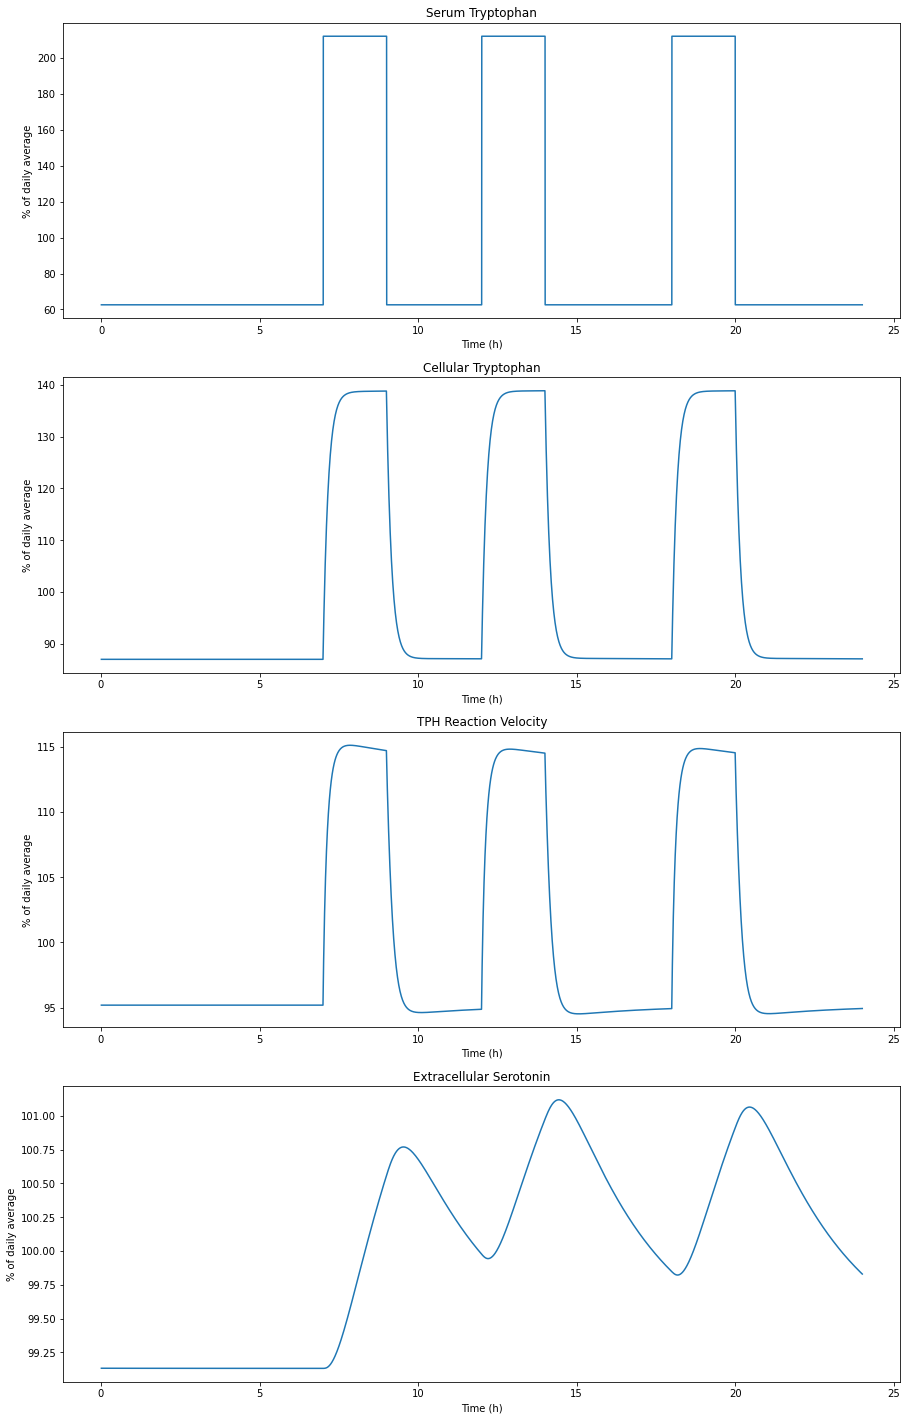

In [220]:
%matplotlib inline

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (15,25))
ax1.plot(btrp_data2[:,0], btrp_data2[:,1]/btrp_data2_mean*100)
ax1.set(title = "Serum Tryptophan", xlabel = "Time (h)", ylabel = "% of daily average")
ax2.plot(data[:,0], data[:,3]/trp_mean*100)
ax2.set(title = "Cellular Tryptophan", xlabel = "Time (h)", ylabel = "% of daily average")
ax3.plot(data[:,0], data_TPH/tph_mean*100)
ax3.set(title = "TPH Reaction Velocity", xlabel = "Time (h)", ylabel = "% of daily average")
ax4.plot(data[:,0], data[:,7]/e5ht_mean*100)
ax4.set(title = "Extracellular Serotonin", xlabel = "Time (h)", ylabel = "% of daily average")

In [114]:
steady_state = [data[-1,1], data[-1,2], data[-1,3], data[-1,4], data[-1,5], data[-1,6], data[-1,7], data[-1,8], data[-1,9]]

In [265]:
%%time

data = model(params, steady_state, timeLength)

CPU times: user 85.9 ms, sys: 8.11 ms, total: 94.1 ms
Wall time: 93.1 ms


In [171]:
print(btrp_data)

0.0001242564463151229


### Results B

In [ ]:
# So on this one, we change fire(t) to return 5000 rather than 1 for 1/5 of a second
# so if (0 <= t <= 0.2)
# except we will need to change the scale to seconds and run for 10 seconds rather than 24 hours

In [263]:
# save results in array for plotting
data_normal = data

In [266]:
data_fluox = data

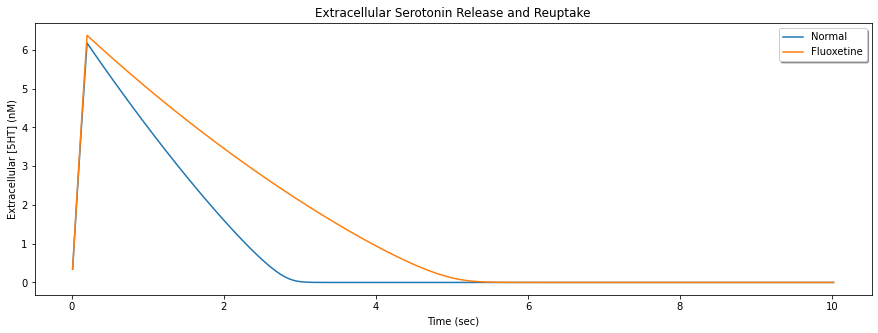

In [267]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(data_normal[:,0], data_normal[:,7], label = "Normal")
ax.plot(data_fluox[:,0], data_fluox[:,7], label = "Fluoxetine")
ax.set(title = "Extracellular Serotonin Release and Reuptake", xlabel = "Time (sec)", ylabel = "Extracellular [5HT] (nM)")
ax.legend(fancybox = True, shadow = True, loc = "upper right")

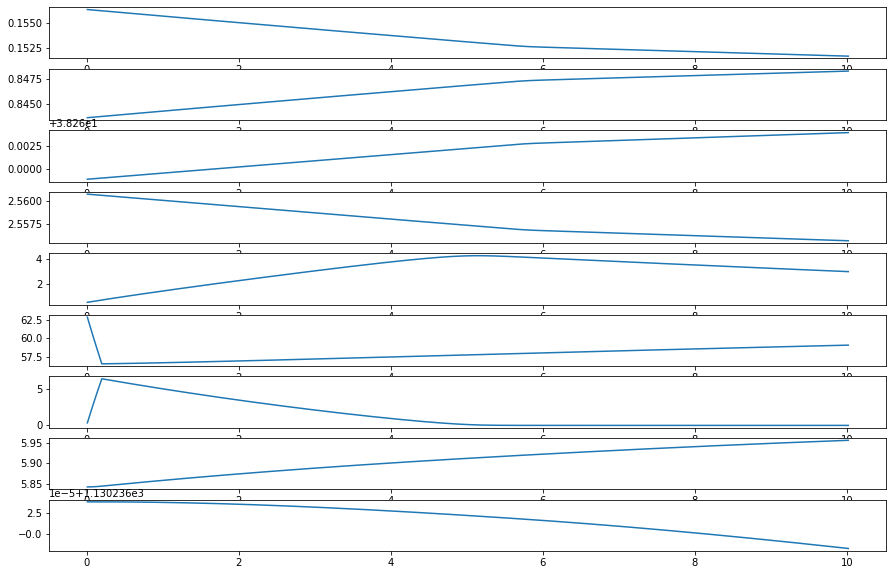

In [268]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9) = plt.subplots(nrows=9, figsize=(15,10))
ax1.plot(data[:,0], data[:,1])
ax2.plot(data[:,0], data[:,2])
ax3.plot(data[:,0], data[:,3])
ax4.plot(data[:,0], data[:,4])
ax5.plot(data[:,0], data[:,5])
ax6.plot(data[:,0], data[:,6])
ax7.plot(data[:,0], data[:,7])
ax8.plot(data[:,0], data[:,8])
ax9.plot(data[:,0], data[:,9])

In [255]:
steady_state = [np.mean(data[-10:-1,1]),np.mean(data[-10:-1,2]),np.mean(data[-10:-1,3]),np.mean(data[-10:-1,4]),np.mean(data[-10:-1,5]),np.mean(data[-10:-1,6]),np.mean(data[-10:-1,7]),np.mean(data[-10:-1,8]),np.mean(data[-10:-1,9])]

In [256]:
print(steady_state)

[0.1563800506525295, 0.8436199493472093, 38.258911909389006, 2.5607419188454523, 0.5572650960101965, 63.21346934013257, 0.0011430932897195302, 5.843772111219993, 1130.2360388264915]
